In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.utils.class_weight import compute_class_weight
from yellowbrick.classifier import ClassificationReport

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

SEED = 42

np.random.seed(SEED)
random.seed(SEED)

In [2]:
from imblearn.under_sampling import ClusterCentroids, \
                                    CondensedNearestNeighbour, \
                                    EditedNearestNeighbours, \
                                    RepeatedEditedNearestNeighbours, \
                                    AllKNN, \
                                    InstanceHardnessThreshold, \
                                    NearMiss, \
                                    NeighbourhoodCleaningRule, \
                                    OneSidedSelection, \
                                    TomekLinks


from imblearn.over_sampling import SMOTE, \
                                   ADASYN, \
                                   BorderlineSMOTE, \
                                   KMeansSMOTE, \
                                   SVMSMOTE

from imblearn.combine import SMOTETomek, SMOTEENN

In [3]:
df = pd.read_csv("../input/creditcardfraud/creditcard.csv")

df.info()

df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [4]:
df.describe().round(4)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,...,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000,284807.0000
mean,94813.8596,0.0000,0.0000,-0.0000,0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000,-0.0000,88.3496,0.0017
std,47488.1460,1.9587,1.6513,1.5163,1.4159,1.3802,1.3323,1.2371,1.1944,1.0986,...,0.7345,0.7257,0.6245,0.6056,0.5213,0.4822,0.4036,0.3301,250.1201,0.0415
min,0.0000,-56.4075,-72.7157,-48.3256,-5.6832,-113.7433,-26.1605,-43.5572,-73.2167,-13.4341,...,-34.8304,-10.9331,-44.8077,-2.8366,-10.2954,-2.6046,-22.5657,-15.4301,0.0000,0.0000
25%,54201.5000,-0.9204,-0.5985,-0.8904,-0.8486,-0.6916,-0.7683,-0.5541,-0.2086,-0.6431,...,-0.2284,-0.5424,-0.1618,-0.3546,-0.3171,-0.3270,-0.0708,-0.0530,5.6000,0.0000
50%,84692.0000,0.0181,0.0655,0.1798,-0.0198,-0.0543,-0.2742,0.0401,0.0224,-0.0514,...,-0.0295,0.0068,-0.0112,0.0410,0.0166,-0.0521,0.0013,0.0112,22.0000,0.0000
75%,139320.5000,1.3156,0.8037,1.0272,0.7433,0.6119,0.3986,0.5704,0.3273,0.5971,...,0.1864,0.5286,0.1476,0.4395,0.3507,0.2410,0.0910,0.0783,77.1650,0.0000
max,172792.0000,2.4549,22.0577,9.3826,16.8753,34.8017,73.3016,120.5895,20.0072,15.5950,...,27.2028,10.5031,22.5284,4.5845,7.5196,3.5173,31.6122,33.8478,25691.1600,1.0000


In [5]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
df.groupby("Class")["Amount"].agg(["mean", "sum", "count", "min", "max"])

,mean,sum,count,min,max
Class,,,,,
0,88.291022,25102462.04,284315,0.0,25691.16
1,122.211321,60127.97,492,0.0,2125.87


In [7]:
target = "Class"
predictors = [x for x in df.columns if x != target]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df[predictors], 
                                                    df[target], 
                                                    stratify = df[target], 
                                                    test_size = 0.3, 
                                                    random_state = SEED)

In [9]:
scaler = StandardScaler()

for col in ["Time", "Amount"]:
    
    scaler = StandardScaler()
    X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))    

In [10]:
def model_results(model, X_train, y_train, X_test, y_test):
    
    labels = ["Normal", "Fraud"]
    
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    
    model.fit(X_train, y_train)
    
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    train_probas = model.predict_proba(X_train)[:, 1]
    test_probas = model.predict_proba(X_test)[:, 1]
    
    cm_train = confusion_matrix(y_train, train_preds,# normalize = "pred"
                               )
    cm_test = confusion_matrix(y_test, test_preds, #normalize = "pred"
                              )
    
    df_cm_train = pd.DataFrame(cm_train, index = labels, columns = labels)
    df_cm_test = pd.DataFrame(cm_test, index = labels, columns = labels)
    
    sns.heatmap(df_cm_train, annot = True, annot_kws = {"fontsize": 9}, fmt = "6d",
                linewidths = 0.01, linecolor = "black", cmap = "Blues", cbar = False, ax = axes[0])
    
    sns.heatmap(df_cm_test, annot = True, annot_kws = {"fontsize": 9}, fmt = "6d",
                linewidths = 0.01, linecolor = "black", cmap = "Blues", cbar = False, ax = axes[1])    
    
    axes[0].set_title("Confusion Matrix for Training Set")
    axes[1].set_title("Confusion Matrix for Test Set")    
    
    for ax in axes:
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        
    print("For training set: \n")
    print(classification_report_imbalanced(y_train, train_preds, target_names = ["Normal", "Fraud"], digits = 3))
    print("Roc-Auc Score: " , roc_auc_score(y_train, train_probas).round(4), "\n")
 
    print("For test set: \n")
    print(classification_report_imbalanced(y_test, test_preds, target_names = ["Normal", "Fraud"], digits = 3))    
    print("Roc-Auc Score: " , roc_auc_score(y_test, test_probas).round(4), "\n")
    
    
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, test_probas)
    test_rocauc = auc(false_positive_rate, true_positive_rate)
    
    fig, ax = plt.subplots(figsize = (12, 6))    
    
    ax.plot(false_positive_rate, true_positive_rate, label = f"AUC: {test_rocauc.round(4)}", color = "#0EB8F1")
    ax.legend(loc = "upper left")
    ax.plot([0, 1], [0, 1], linestyle = "--", color = "#F1480F")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC Curve For Test Set")
    ax.grid(linewidth = 0.2)
    
    
    ap = average_precision_score(y_test, test_probas)
    
    precision, recall, _ = precision_recall_curve(y_test, test_probas)
    
    fig, ax = plt.subplots(figsize = (12, 6))
    
    ax.plot(precision, recall, label = f"Average Precision Score: {ap.round(4)}", color = "#0EB8F1")
    ax.legend(loc = "lower left")
    ax.set_xlabel("Precision")
    ax.set_ylabel("Recall")
    ax.set_title("Precision Recall Curve for Test Set")
    ax.grid(linewidth = 0.2)    

In [11]:
class_weights = compute_class_weight("balanced", classes = np.unique(y_train), y = y_train)

class_weights

array([  0.50086423, 289.77325581])

In [12]:
344 / (344 + 19952)

0.01694915254237288

In [13]:
smote = SMOTE(sampling_strategy = "not majority", random_state = SEED) 
smote_01 = SMOTE(sampling_strategy = 0.1, random_state = SEED)
smote_05 = SMOTE(sampling_strategy = 0.5, random_state = SEED)

adasyn = ADASYN(sampling_strategy = "not majority", random_state = SEED) 
adasyn_01 = ADASYN(sampling_strategy = 0.1, random_state = SEED)
adasyn_05 = ADASYN(sampling_strategy = 0.5, random_state = SEED)

In [14]:
Xtr_smote, ytr_smote = smote.fit_resample(X_train, y_train)
Xtr_smote_01, ytr_smote_01 = smote_01.fit_resample(X_train, y_train)
Xtr_smote_05, ytr_smote_05 = smote_05.fit_resample(X_train, y_train)

In [15]:
lgbc = lgb.LGBMClassifier(random_state = SEED, n_jobs = -1)
lgbc_balanced = lgb.LGBMClassifier(random_state = SEED, n_jobs = -1, class_weight = "balanced")
# lgbc_smote = Pipeline([("smote", smote), ("clf", lgbc)])
# lgbc_smote_01 = Pipeline([("smote", smote_01), ("clf", lgbc)])
# lgbc_smote_05 = Pipeline([("smote", smote_05), ("clf", lgbc)])

# lgbc_tomek = Pipeline([("tomek", tomek), ("clf", lgbc)])
# lgbc_tomek_05 = Pipeline([("tomek", tomek_05), ("clf", lgbc)])
# lgbc_tomek_01 = Pipeline([("tomek", tomek_01), ("clf", lgbc)])


# Default LightGBM

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      0.999     0.999     0.599     0.999     0.773     0.622    199020
      Fraud      0.424     0.599     0.999     0.496     0.773     0.574       344

avg / total      0.998     0.998     0.600     0.998     0.773     0.622    199364

Roc-Auc Score:  0.8142 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      0.999     0.998     0.601     0.999     0.775     0.624     85295
      Fraud      0.368     0.601     0.998     0.456     0.775     0.576       148

avg / total      0.998     0.998     0.602     0.998     0.775     0.624     85443

Roc-Auc Score:  0.8012 



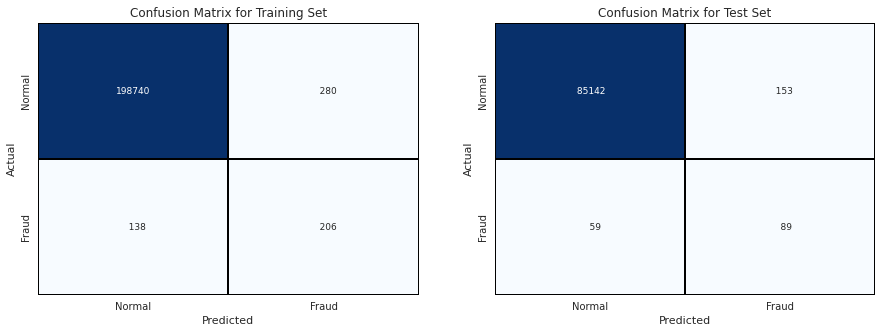

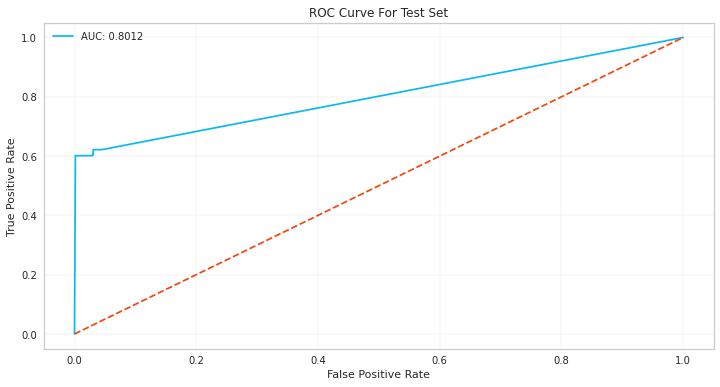

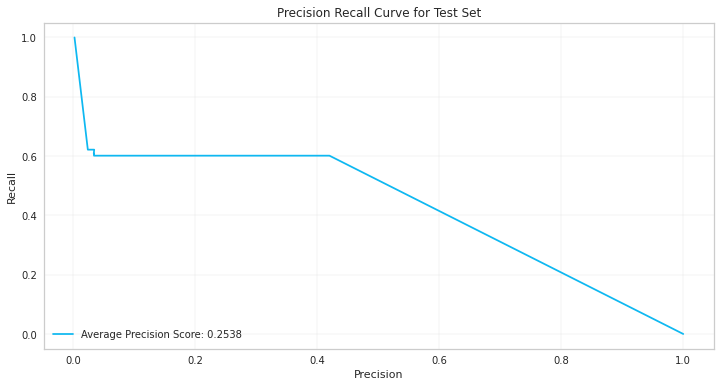

In [16]:
model_results(lgbc, X_train, y_train, X_test, y_test)

# LightGBM (Class Weights)

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000    199020
      Fraud      0.977     1.000     1.000     0.989     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000    199364

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     0.804     1.000     0.897     0.820     85295
      Fraud      0.844     0.804     1.000     0.824     0.897     0.788       148

avg / total      0.999     0.999     0.804     0.999     0.897     0.820     85443

Roc-Auc Score:  0.9701 



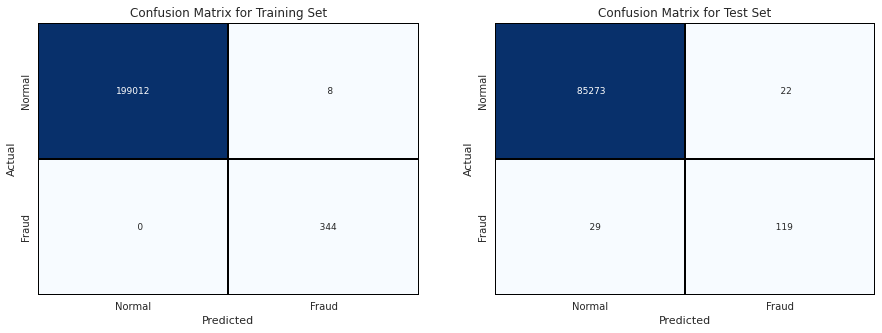

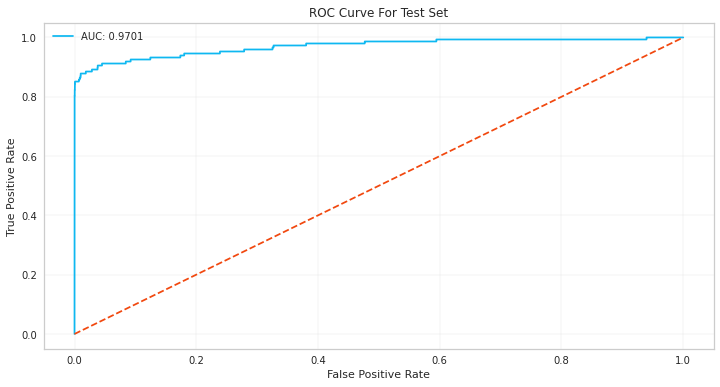

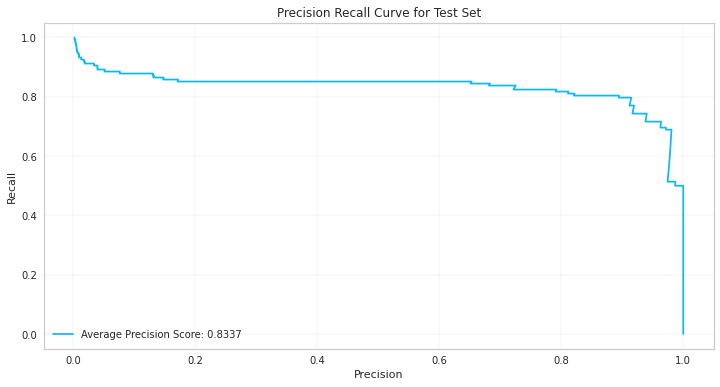

In [17]:
model_results(lgbc_balanced, X_train, y_train, X_test, y_test)

# LightGBM SMOTE, 50-50 (1/1)

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.999     1.000     1.000     1.000     0.999    199020
      Fraud      0.999     1.000     0.999     1.000     1.000     0.999    199020

avg / total      1.000     1.000     1.000     1.000     1.000     0.999    398040

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.999     0.838     0.999     0.915     0.850     85295
      Fraud      0.554     0.838     0.999     0.667     0.915     0.823       148

avg / total      0.999     0.999     0.838     0.999     0.915     0.850     85443

Roc-Auc Score:  0.9551 



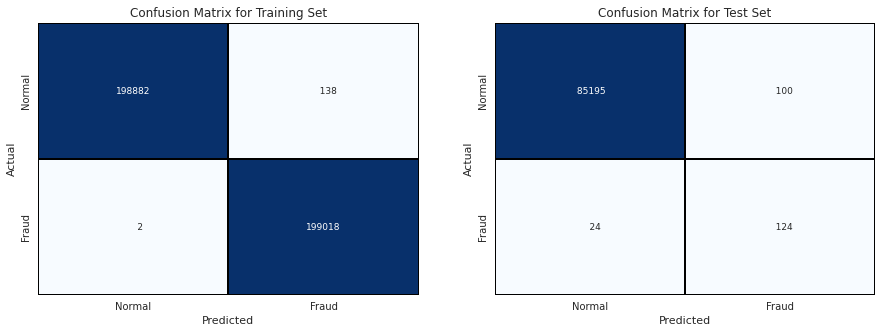

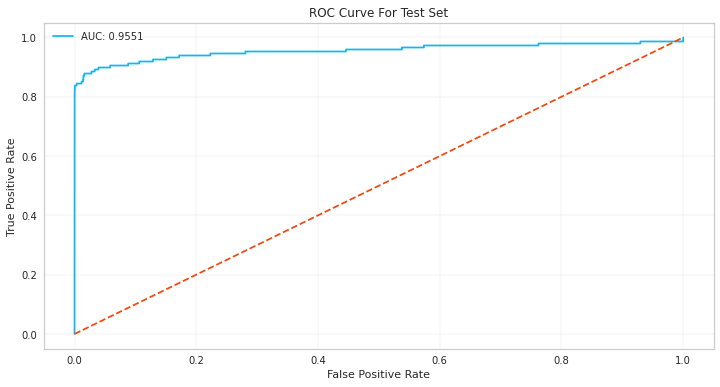

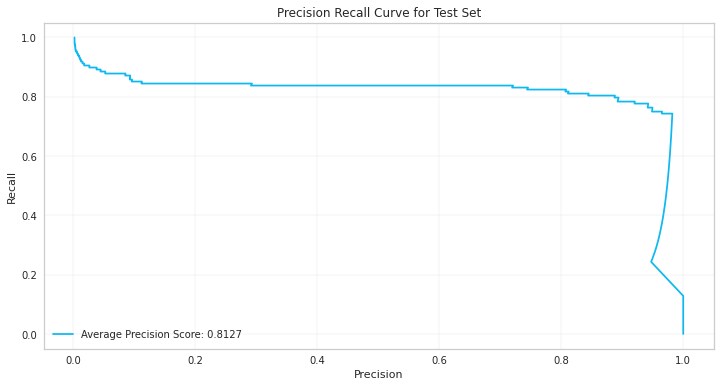

In [18]:
model_results(lgbc, Xtr_smote, ytr_smote, X_test, y_test)

# LightGBM SMOTE, 1/10

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000    199020
      Fraud      1.000     1.000     1.000     1.000     1.000     0.999     19902

avg / total      1.000     1.000     1.000     1.000     1.000     1.000    218922

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     0.824     1.000     0.908     0.839     85295
      Fraud      0.841     0.824     1.000     0.833     0.908     0.810       148

avg / total      0.999     0.999     0.825     0.999     0.908     0.839     85443

Roc-Auc Score:  0.9699 



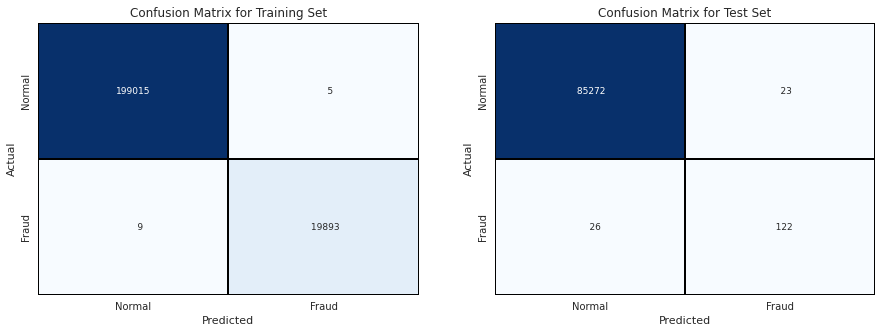

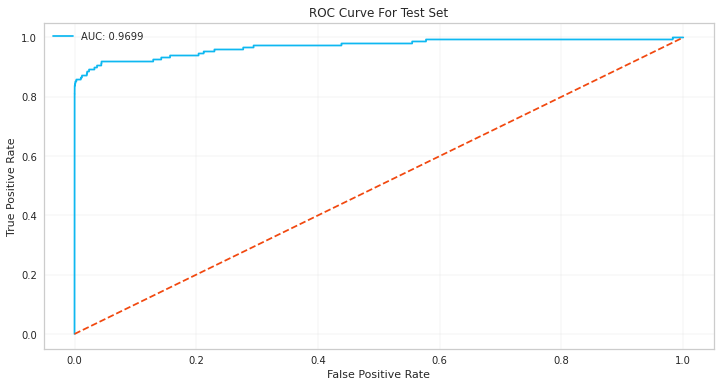

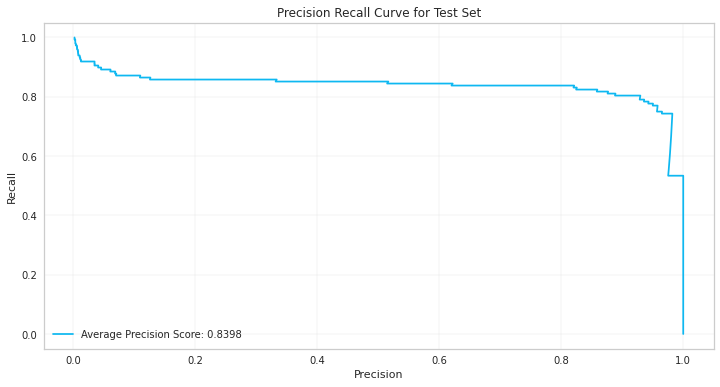

In [19]:
model_results(lgbc, Xtr_smote_01, ytr_smote_01, X_test, y_test)

# LightGBM SMOTE, 1/5

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000    199020
      Fraud      0.999     1.000     1.000     1.000     1.000     1.000     99510

avg / total      1.000     1.000     1.000     1.000     1.000     1.000    298530

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.999     0.831     0.999     0.911     0.844     85295
      Fraud      0.658     0.831     0.999     0.734     0.911     0.816       148

avg / total      0.999     0.999     0.831     0.999     0.911     0.844     85443

Roc-Auc Score:  0.9676 



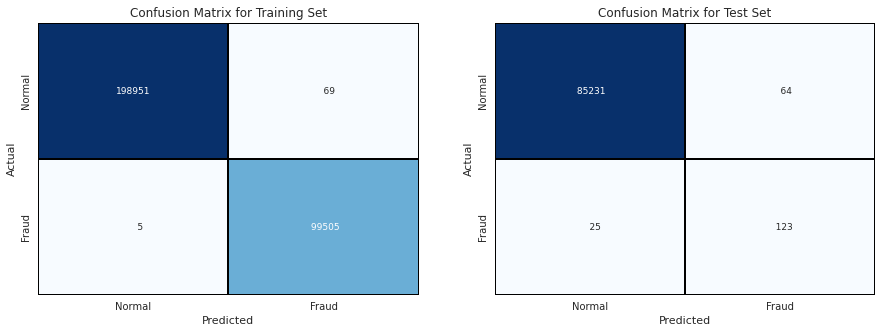

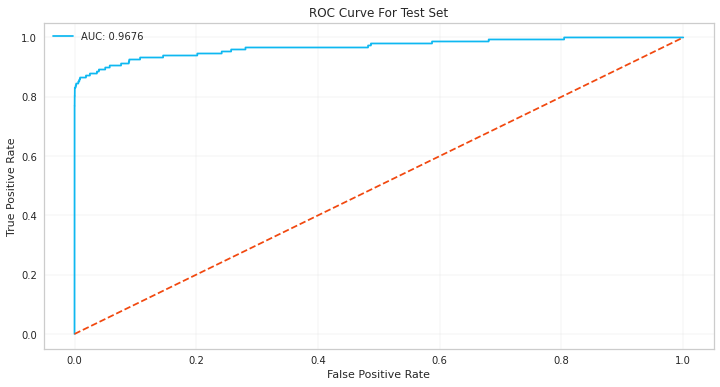

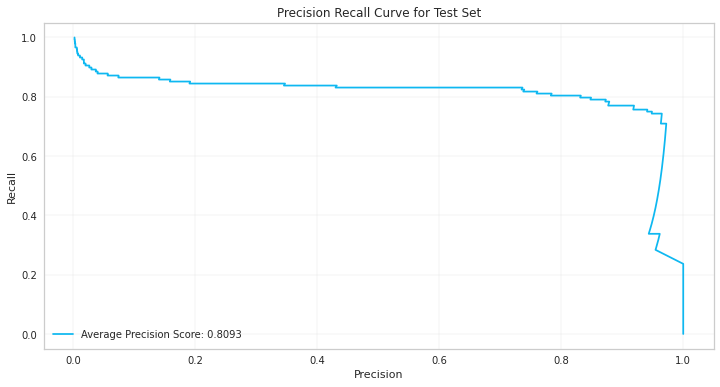

In [20]:
model_results(lgbc, Xtr_smote_05, ytr_smote_05, X_test, y_test)

In [21]:
Xtr_adasyn, ytr_adasyn = adasyn.fit_resample(X_train, y_train)
Xtr_adasyn_01, ytr_adasyn_01 = adasyn_01.fit_resample(X_train, y_train)
Xtr_adasyn_05, ytr_adasyn_05 = adasyn_05.fit_resample(X_train, y_train)

# LightGBM, ADASYN

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.999     1.000     0.999     0.999     0.999    199020
      Fraud      0.999     1.000     0.999     0.999     0.999     0.999    199034

avg / total      0.999     0.999     0.999     0.999     0.999     0.999    398054

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.998     0.743     0.999     0.861     0.761     85295
      Fraud      0.374     0.743     0.998     0.498     0.861     0.723       148

avg / total      0.998     0.997     0.744     0.998     0.861     0.760     85443

Roc-Auc Score:  0.9067 



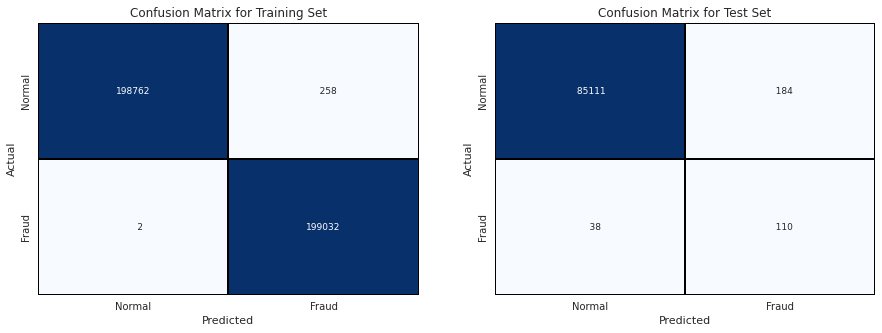

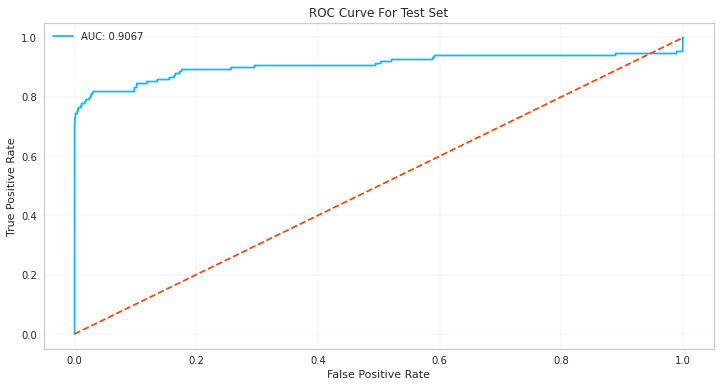

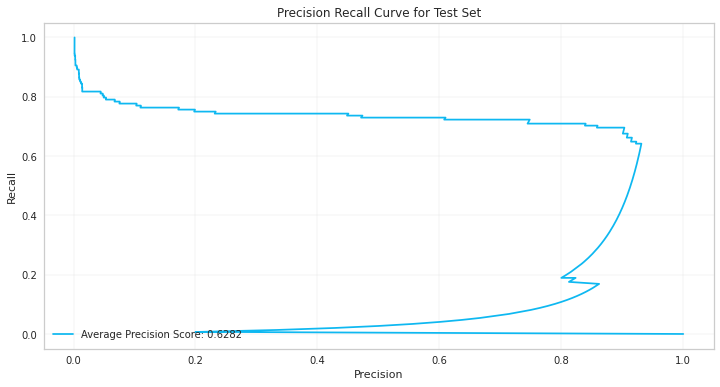

In [22]:
model_results(lgbc, Xtr_adasyn, ytr_adasyn, X_test, y_test)

# LightGBM, ADASYN, 1/10

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000    199020
      Fraud      0.998     1.000     1.000     0.999     1.000     1.000     19900

avg / total      1.000     1.000     1.000     1.000     1.000     1.000    218920

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.999     0.811     1.000     0.900     0.826     85295
      Fraud      0.702     0.811     0.999     0.752     0.900     0.795       148

avg / total      0.999     0.999     0.811     0.999     0.900     0.826     85443

Roc-Auc Score:  0.9689 



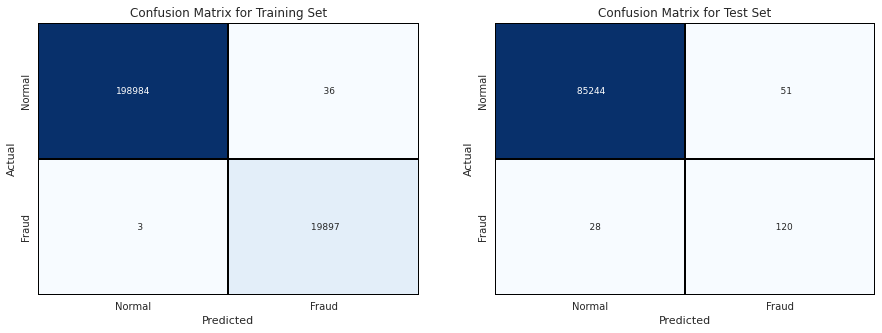

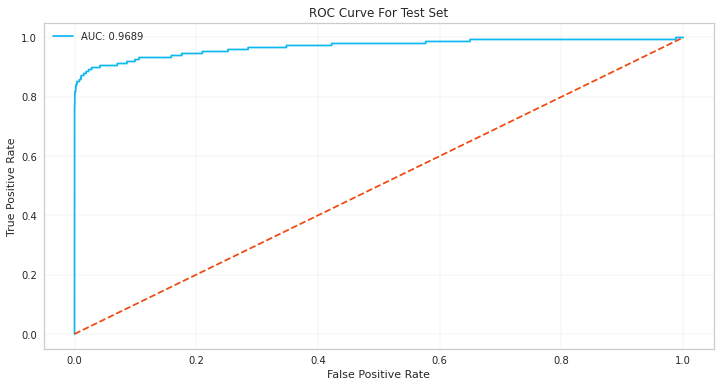

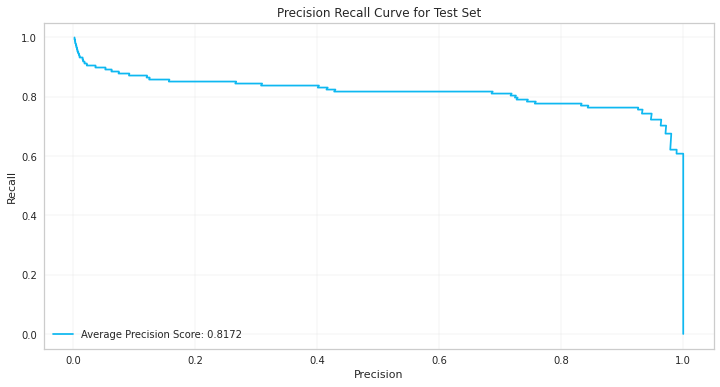

In [23]:
model_results(lgbc, Xtr_adasyn_01, ytr_adasyn_01, X_test, y_test)

# LightGBM, ADASYN, 1/5

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.999     1.000     1.000     1.000     0.999    199020
      Fraud      0.998     1.000     0.999     0.999     1.000     0.999     99494

avg / total      0.999     0.999     1.000     0.999     1.000     0.999    298514

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.999     0.777     0.999     0.881     0.793     85295
      Fraud      0.511     0.777     0.999     0.617     0.881     0.759       148

avg / total      0.999     0.998     0.777     0.998     0.881     0.793     85443

Roc-Auc Score:  0.9346 



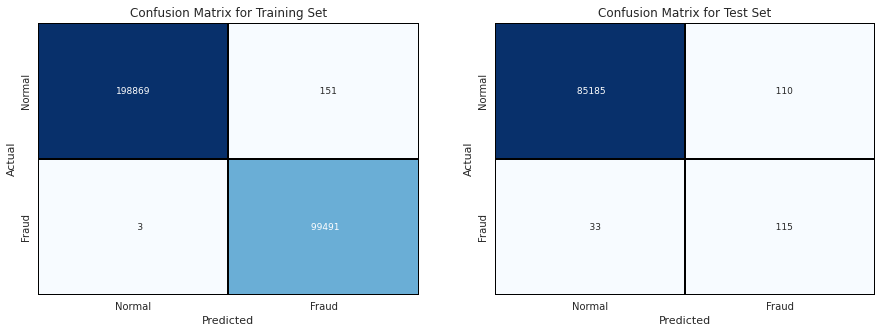

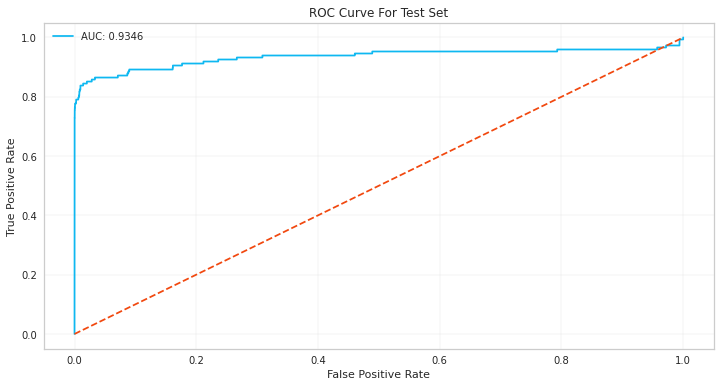

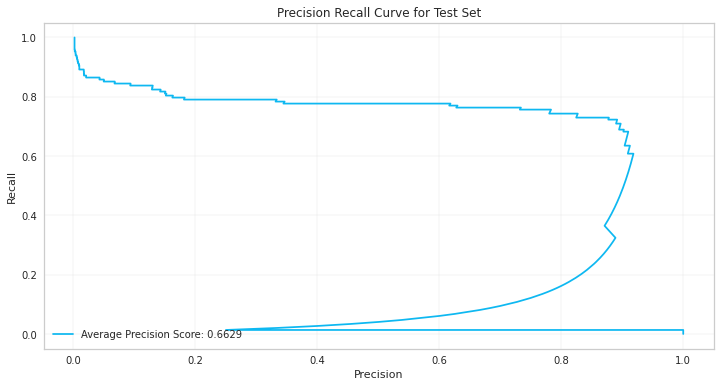

In [24]:
model_results(lgbc, Xtr_adasyn_05, ytr_adasyn_05, X_test, y_test)

In [25]:
nearmiss1 = NearMiss(sampling_strategy="not minority", version=1, n_neighbors=3, n_jobs=-1)
nearmiss2 = NearMiss(sampling_strategy="not minority", version=2, n_neighbors=3, n_jobs=-1)
nearmiss3 = NearMiss(sampling_strategy="not minority", version=3, n_neighbors=3, n_jobs=-1)

nearmiss1_01 = NearMiss(sampling_strategy= 0.1, version=1, n_neighbors=3, n_jobs=-1)
nearmiss2_01 = NearMiss(sampling_strategy=0.1, version=2, n_neighbors=3, n_jobs=-1)
nearmiss3_01 = NearMiss(sampling_strategy=0.1, version=3, n_neighbors=3, n_jobs=-1)

nearmiss1_001 = NearMiss(sampling_strategy= 0.01, version=1, n_neighbors=3, n_jobs=-1)
nearmiss2_001 = NearMiss(sampling_strategy=0.01, version=2, n_neighbors=3, n_jobs=-1)
nearmiss3_001 = NearMiss(sampling_strategy=0.01, version=3, n_neighbors=3, n_jobs=-1)

In [26]:
Xtr_nm1, ytr_nm1 = nearmiss1.fit_resample(X_train, y_train)
Xtr_nm2, ytr_nm2 = nearmiss2.fit_resample(X_train, y_train)
Xtr_nm3, ytr_nm3 = nearmiss3.fit_resample(X_train, y_train)

Xtr_nm1_01, ytr_nm1_01 = nearmiss1_01.fit_resample(X_train, y_train)
Xtr_nm2_01, ytr_nm2_01 = nearmiss2_01.fit_resample(X_train, y_train)
Xtr_nm3_01, ytr_nm3_01 = nearmiss3_01.fit_resample(X_train, y_train)

Xtr_nm1_001, ytr_nm1_001 = nearmiss1_001.fit_resample(X_train, y_train)
Xtr_nm2_001, ytr_nm2_001 = nearmiss2_001.fit_resample(X_train, y_train)
Xtr_nm3_001, ytr_nm3_001 = nearmiss3_001.fit_resample(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:176: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"
/opt/conda/lib/python3.7/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:176: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"
/opt/conda/lib/python3.7/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:176: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  "The number of the samples to be selected is larger"


# LightGBM, NearMiss Version 1, minimum average distance to three closest minority class examples

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000       344
      Fraud      1.000     1.000     1.000     1.000     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000       688

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.238     0.946     0.385     0.475     0.209     85295
      Fraud      0.002     0.946     0.238     0.004     0.475     0.241       148

avg / total      0.998     0.240     0.945     0.384     0.475     0.210     85443

Roc-Auc Score:  0.8571 



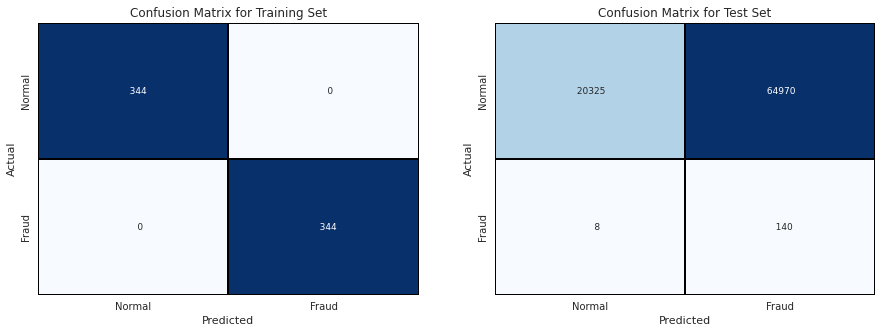

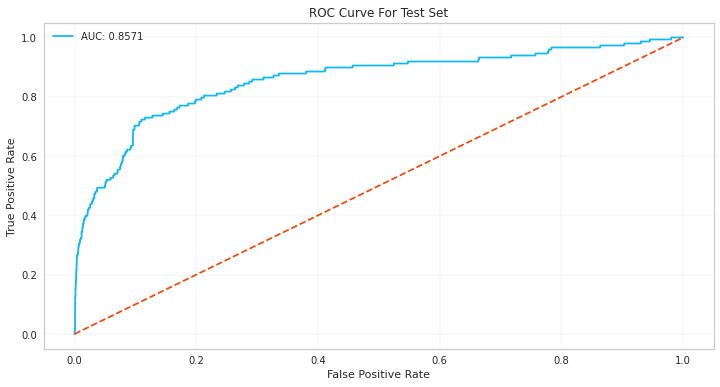

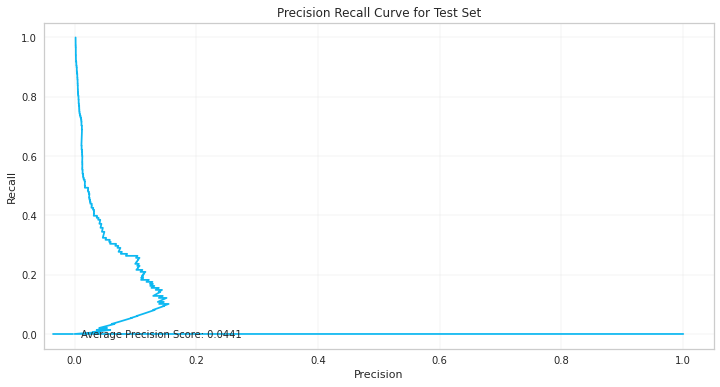

In [27]:
model_results(lgbc, Xtr_nm1, ytr_nm1, X_test, y_test)

# LightGBM, NearMiss Version 2, minimum average distance to three furthest minority class examples.

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000       344
      Fraud      1.000     1.000     1.000     1.000     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000       688

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      0.998     0.014     0.986     0.029     0.119     0.013     85295
      Fraud      0.002     0.986     0.014     0.003     0.119     0.016       148

avg / total      0.997     0.016     0.985     0.028     0.119     0.013     85443

Roc-Auc Score:  0.6489 



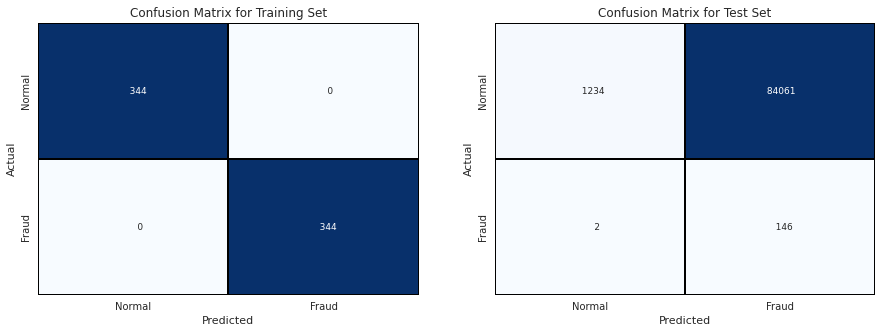

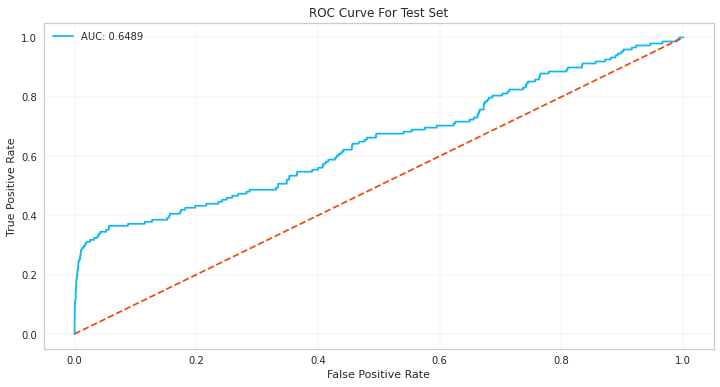

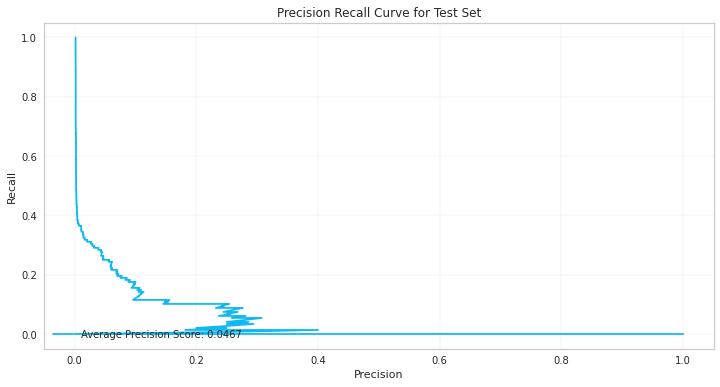

In [28]:
model_results(lgbc, Xtr_nm2, ytr_nm2, X_test, y_test)

# LightGBM, NearMiss Version 3, minimum distance to each minority class example.

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000       276
      Fraud      1.000     1.000     1.000     1.000     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000       620

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.939     0.804     0.969     0.869     0.766     85295
      Fraud      0.023     0.804     0.939     0.044     0.869     0.745       148

avg / total      0.998     0.939     0.804     0.967     0.869     0.766     85443

Roc-Auc Score:  0.9325 



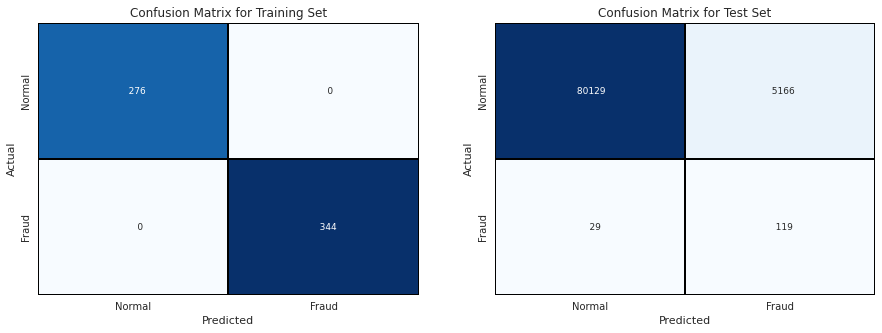

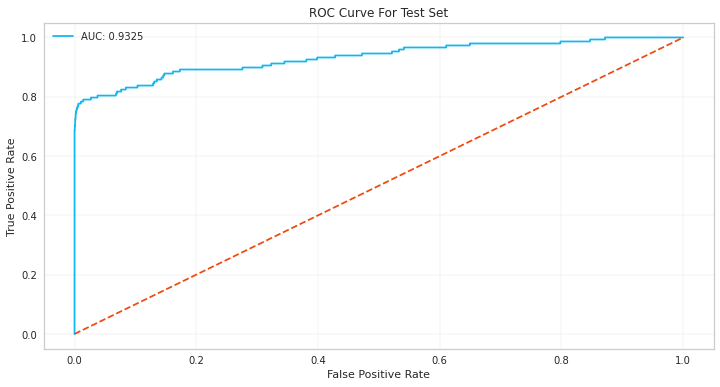

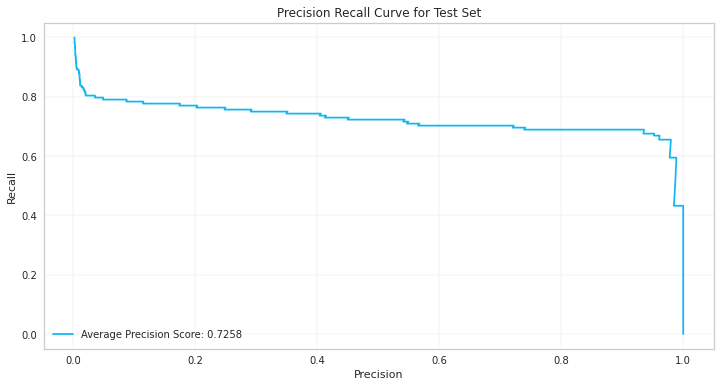

In [29]:
model_results(lgbc, Xtr_nm3, ytr_nm3, X_test, y_test)

# NearMiss Version 1, 1/10

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000      3440
      Fraud      1.000     1.000     1.000     1.000     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000      3784

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.723     0.912     0.839     0.812     0.647     85295
      Fraud      0.006     0.912     0.723     0.011     0.812     0.672       148

avg / total      0.998     0.724     0.912     0.838     0.812     0.647     85443

Roc-Auc Score:  0.9386 



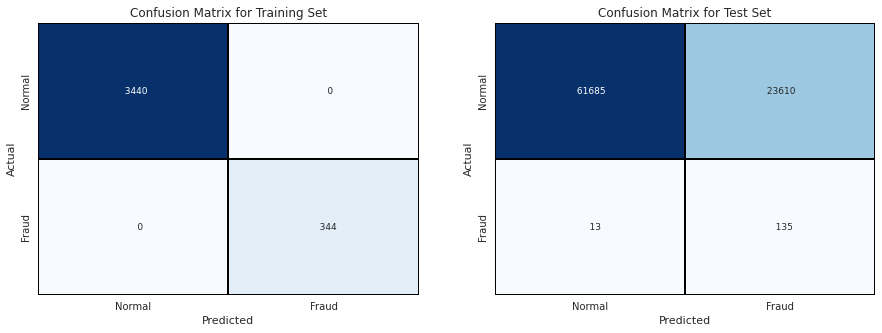

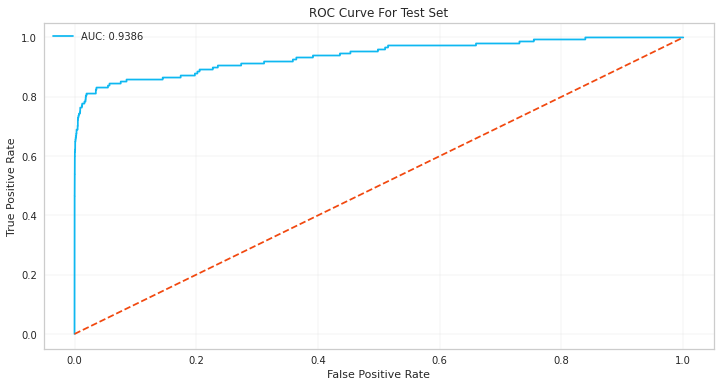

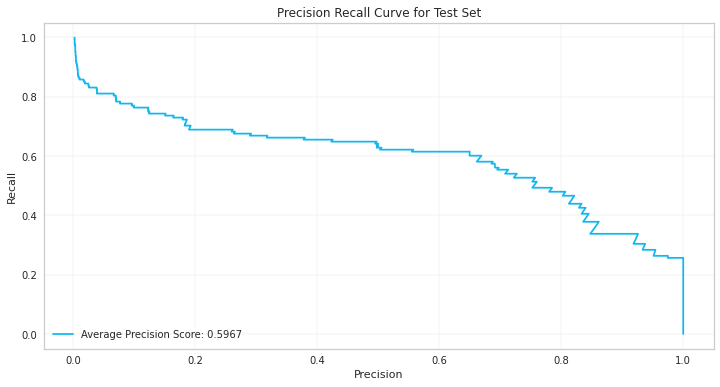

In [30]:
model_results(lgbc, Xtr_nm1_01, ytr_nm1_01, X_test, y_test)

# NearMiss Version 2, 1/10

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000      3440
      Fraud      1.000     1.000     1.000     1.000     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000      3784

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.361     0.919     0.530     0.576     0.313     85295
      Fraud      0.002     0.919     0.361     0.005     0.576     0.350       148

avg / total      0.998     0.362     0.918     0.529     0.576     0.313     85443

Roc-Auc Score:  0.697 



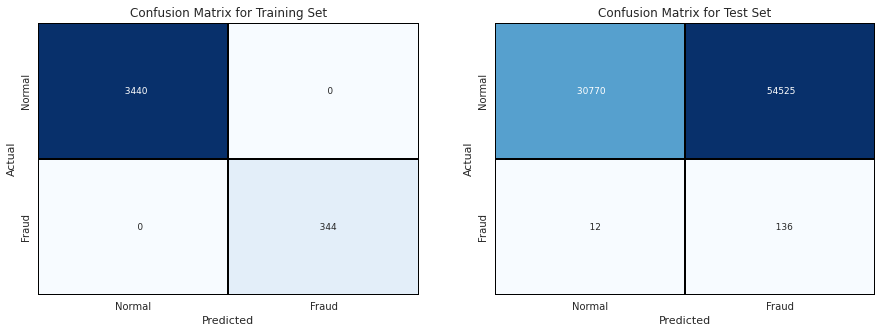

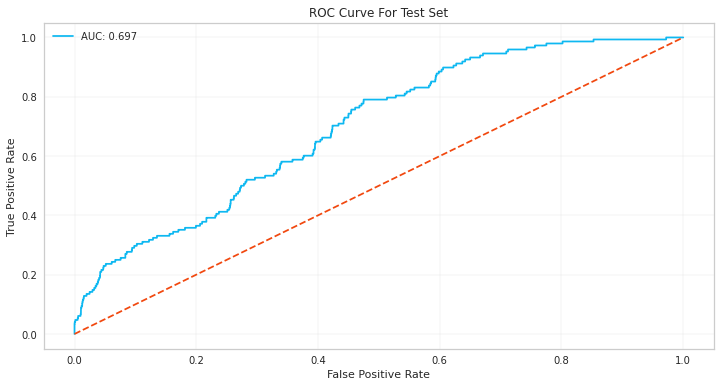

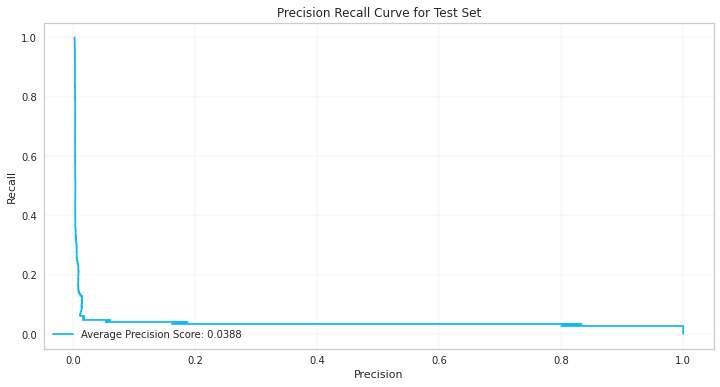

In [31]:
model_results(lgbc, Xtr_nm2_01, ytr_nm2_01, X_test, y_test)

# NearMiss Version 3, 1/10

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000       276
      Fraud      1.000     1.000     1.000     1.000     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000       620

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.939     0.804     0.969     0.869     0.766     85295
      Fraud      0.023     0.804     0.939     0.044     0.869     0.745       148

avg / total      0.998     0.939     0.804     0.967     0.869     0.766     85443

Roc-Auc Score:  0.9325 



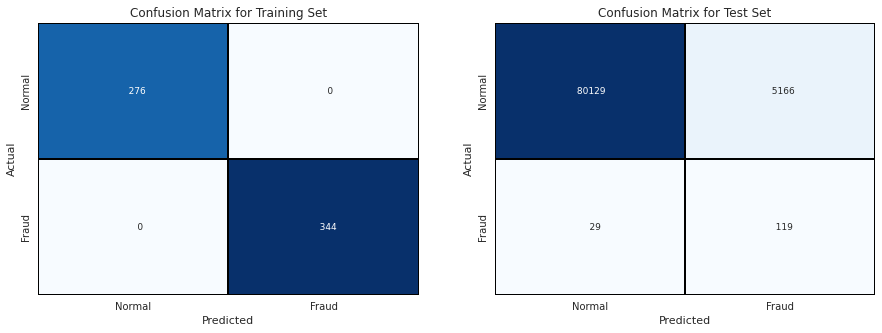

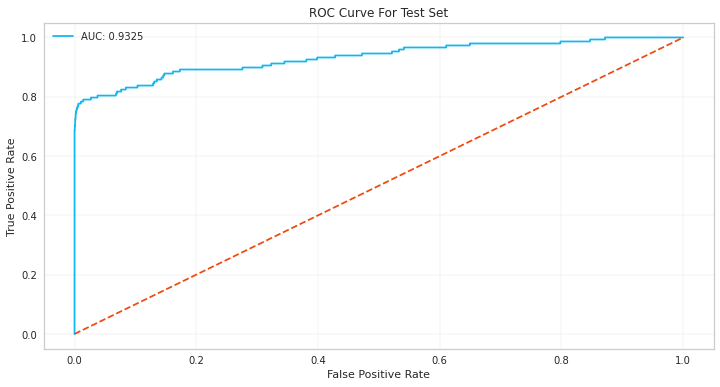

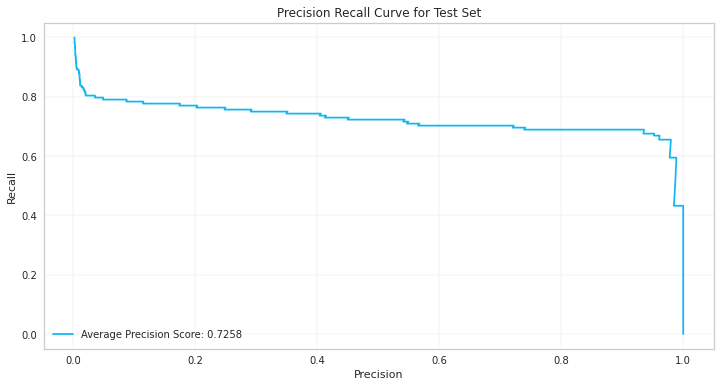

In [32]:
model_results(lgbc, Xtr_nm3_01, ytr_nm3_01, X_test, y_test)

# NearMiss Version1, 1/100

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000     34400
      Fraud      1.000     1.000     1.000     1.000     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000     34744

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.981     0.838     0.990     0.906     0.833     85295
      Fraud      0.070     0.838     0.981     0.129     0.906     0.810       148

avg / total      0.998     0.980     0.838     0.989     0.906     0.833     85443

Roc-Auc Score:  0.9567 



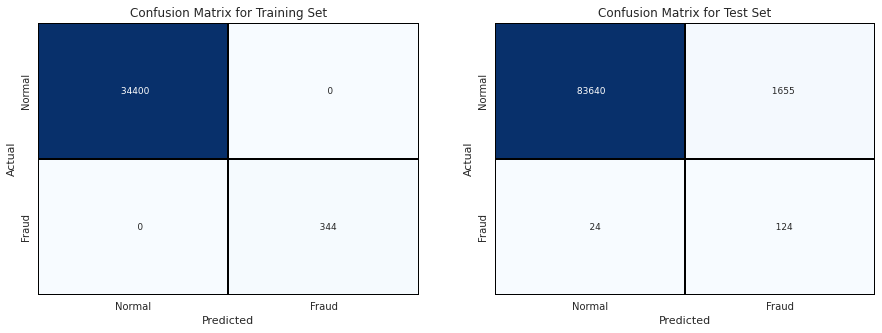

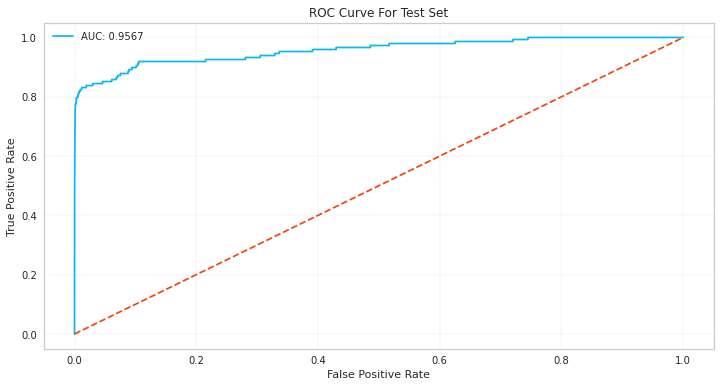

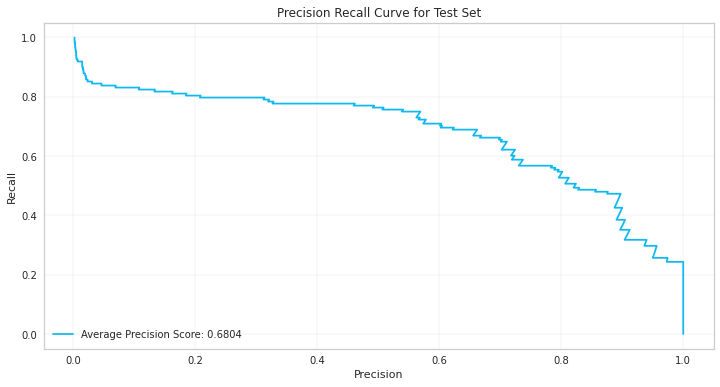

In [33]:
model_results(lgbc, Xtr_nm1_001, ytr_nm1_001, X_test, y_test)

# NearMiss Version2, 1/100

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000     34400
      Fraud      1.000     1.000     1.000     1.000     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000     34744

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      0.999     0.707     0.791     0.828     0.748     0.554     85295
      Fraud      0.005     0.791     0.707     0.009     0.748     0.564       148

avg / total      0.998     0.707     0.790     0.827     0.748     0.555     85443

Roc-Auc Score:  0.8877 



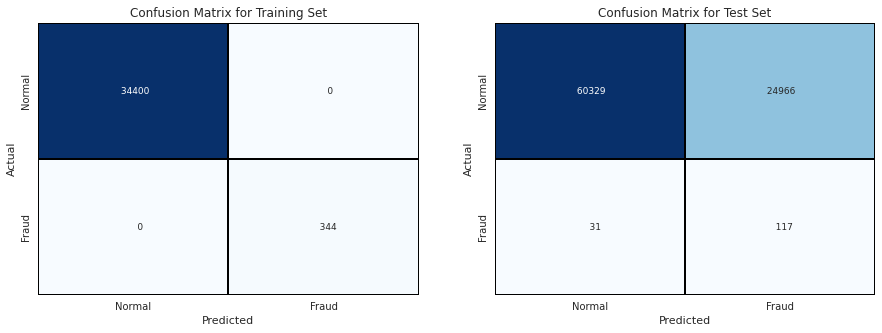

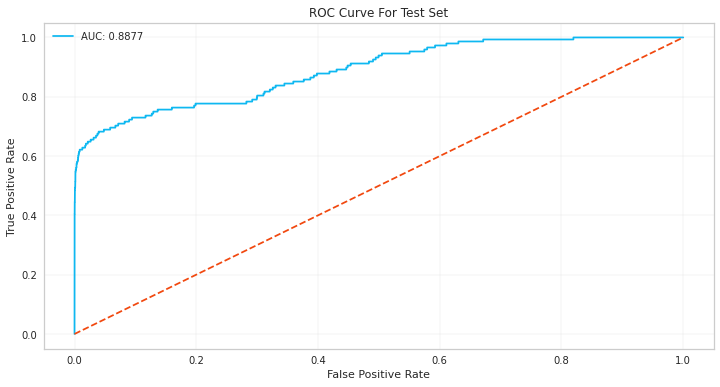

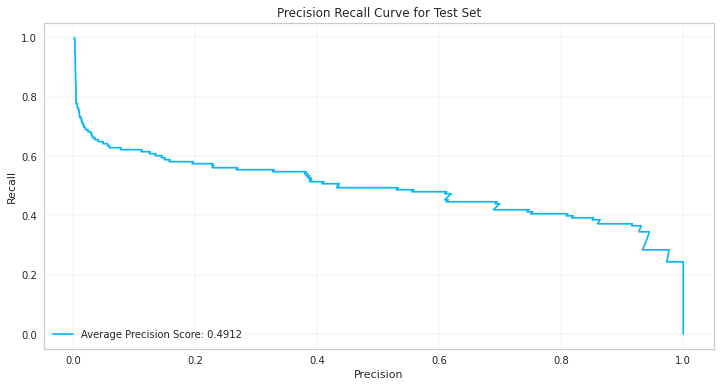

In [34]:
model_results(lgbc, Xtr_nm2_001, ytr_nm2_001, X_test, y_test)

# NearMiss Version3, 1/100

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000       276
      Fraud      1.000     1.000     1.000     1.000     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000       620

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.939     0.804     0.969     0.869     0.766     85295
      Fraud      0.023     0.804     0.939     0.044     0.869     0.745       148

avg / total      0.998     0.939     0.804     0.967     0.869     0.766     85443

Roc-Auc Score:  0.9325 



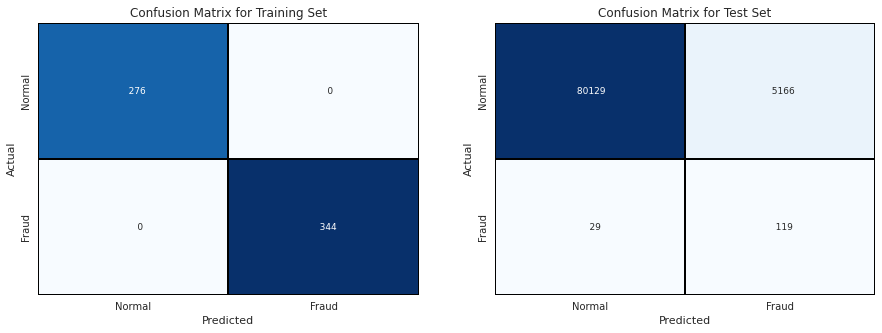

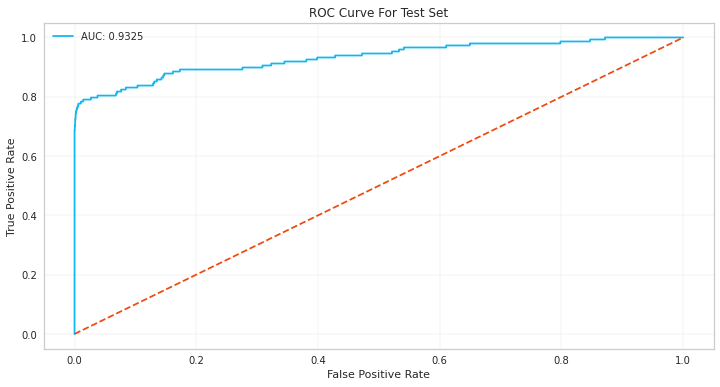

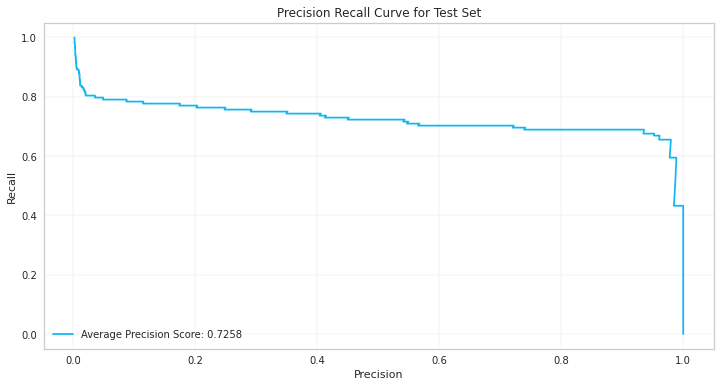

In [35]:
model_results(lgbc, Xtr_nm3_001, ytr_nm3_001, X_test, y_test)

In [36]:
oss = OneSidedSelection(sampling_strategy = "not minority", random_state = SEED, n_neighbors = 3, n_jobs = -1)
oss1000 = OneSidedSelection(sampling_strategy = "not minority", random_state = SEED, n_neighbors = 3, n_jobs = -1, n_seeds_S=1000)
oss10000 = OneSidedSelection(sampling_strategy = "not minority", random_state = SEED, n_neighbors = 3, n_jobs = -1, n_seeds_S=10000)

# OneSidedSelection, Number of samples to extract in order to build the set S = 1

In [37]:
%%time
Xtr_oss, ytr_oss = oss.fit_resample(X_train, y_train)
Xtr_oss.shape

CPU times: user 5min 55s, sys: 124 ms, total: 5min 55s
Wall time: 5min 49s


(199343, 30)

# OneSidedSelection, Number of samples to extract in order to build the set S = 1000

In [38]:
%%time
Xtr_oss1000, ytr_oss1000 = oss1000.fit_resample(X_train, y_train)
Xtr_oss1000.shape

CPU times: user 41.5 s, sys: 40.3 ms, total: 41.5 s
Wall time: 15.9 s


(3344, 30)

# OneSidedSelection, Number of samples to extract in order to build the set S = 10000

In [39]:
%%time
Xtr_oss10000, ytr_oss10000 = oss10000.fit_resample(X_train, y_train)
Xtr_oss10000.shape

CPU times: user 2min 44s, sys: 62.9 ms, total: 2min 44s
Wall time: 48.8 s


(10573, 30)

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.999     0.715     0.999     0.845     0.735    198999
      Fraud      0.520     0.715     0.999     0.602     0.845     0.694       344

avg / total      0.999     0.998     0.716     0.998     0.845     0.734    199343

Roc-Auc Score:  0.8204 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      0.999     0.998     0.581     0.998     0.761     0.604     85295
      Fraud      0.288     0.581     0.998     0.385     0.761     0.555       148

avg / total      0.998     0.997     0.582     0.997     0.761     0.604     85443

Roc-Auc Score:  0.722 



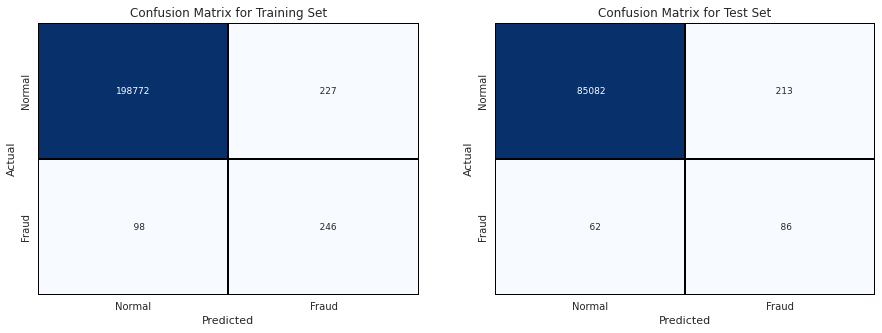

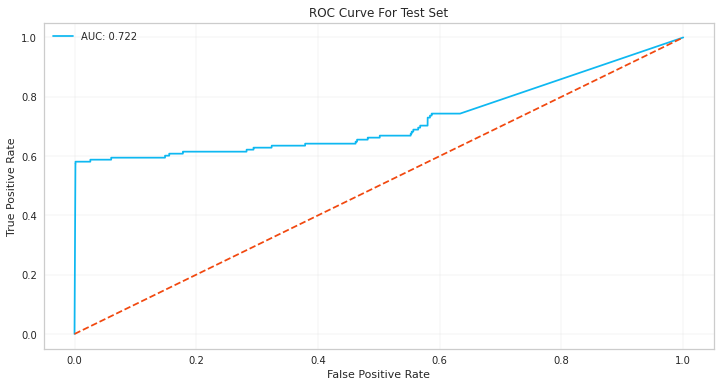

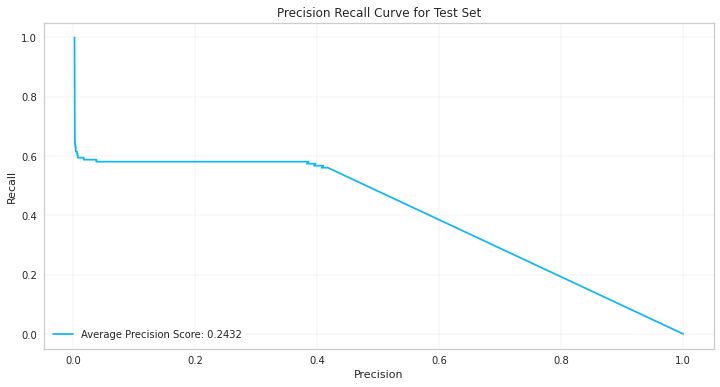

In [40]:
model_results(lgbc, Xtr_oss, ytr_oss, X_test, y_test)

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000      3000
      Fraud      1.000     1.000     1.000     1.000     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000      3344

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     0.770     1.000     0.878     0.788     85295
      Fraud      0.864     0.770     1.000     0.814     0.878     0.752       148

avg / total      0.999     0.999     0.771     0.999     0.878     0.788     85443

Roc-Auc Score:  0.9607 



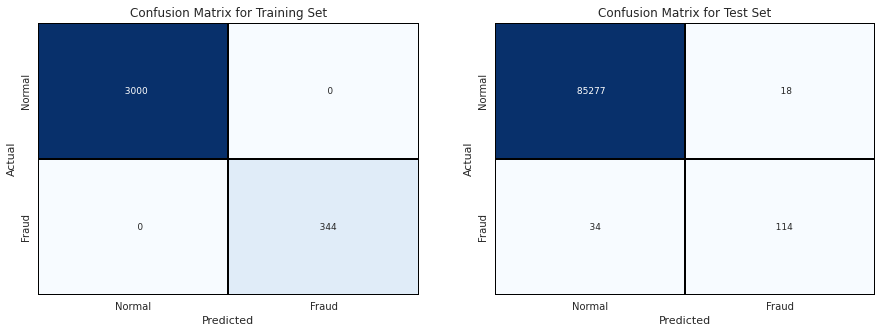

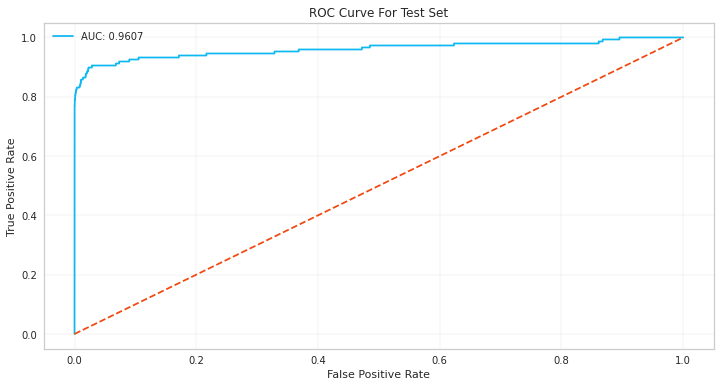

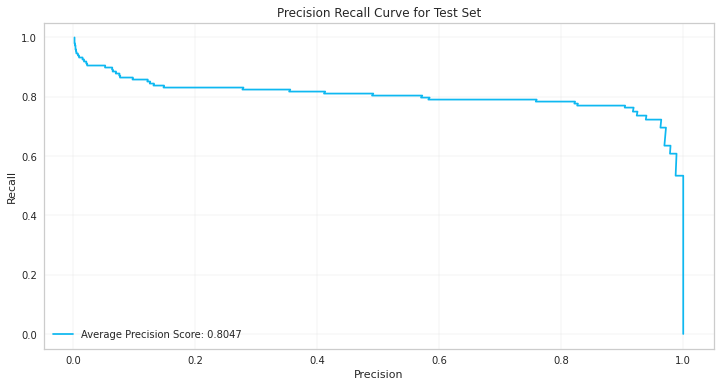

In [41]:
model_results(lgbc, Xtr_oss1000, ytr_oss1000, X_test, y_test)

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000     10229
      Fraud      1.000     1.000     1.000     1.000     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000     10573

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     0.791     1.000     0.889     0.807     85295
      Fraud      0.886     0.791     1.000     0.836     0.889     0.774       148

avg / total      0.999     0.999     0.791     0.999     0.889     0.807     85443

Roc-Auc Score:  0.9769 



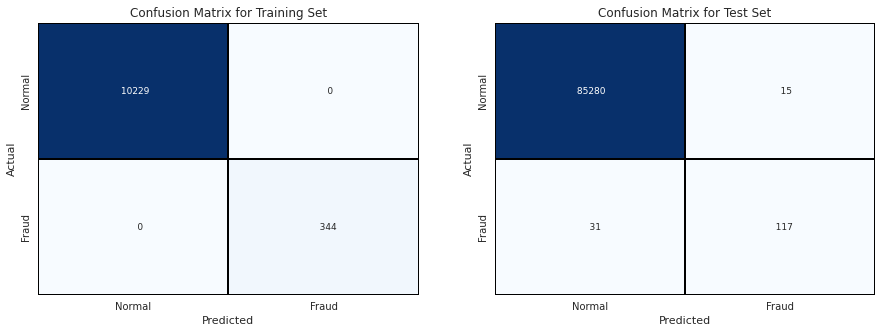

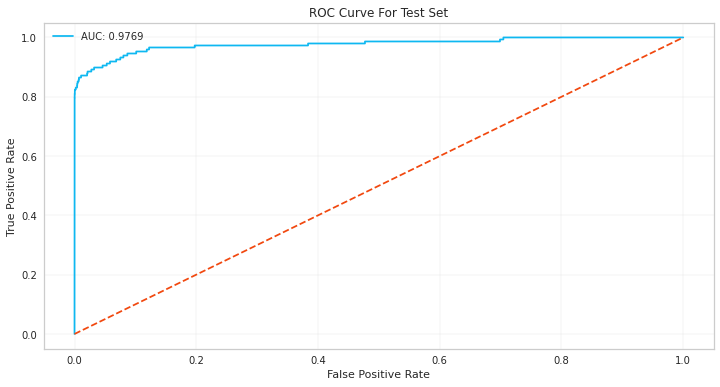

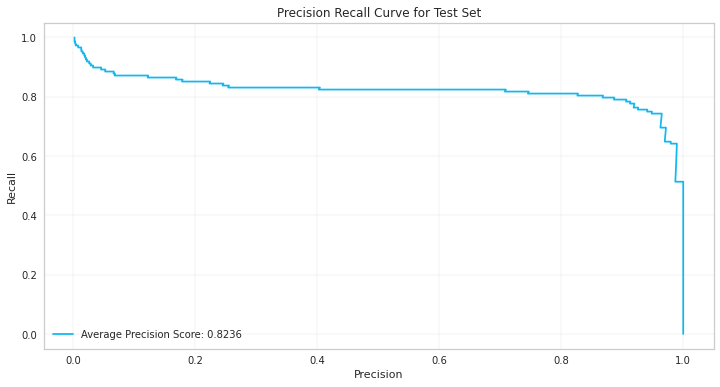

In [42]:
model_results(lgbc, Xtr_oss10000, ytr_oss10000, X_test, y_test)

In [43]:
cnn1 = CondensedNearestNeighbour(sampling_strategy='auto', random_state=SEED, n_neighbors=3, n_seeds_S=1, n_jobs=-1)
cnn1000 = CondensedNearestNeighbour(sampling_strategy='auto', random_state=SEED, n_neighbors=3, n_seeds_S=1000, n_jobs=-1)
cnn10000 = CondensedNearestNeighbour(sampling_strategy='auto', random_state=SEED, n_neighbors=3, n_seeds_S=10000, n_jobs=-1)

In [44]:
# %%time
# Xtr_cnn1, ytr_cnn1 = cnn1.fit_resample(X_train, y_train)

# Xtr_cnn1.to_csv("X_train_cnn_s1.csv")
# ytr_cnn1.to_csv("y_train_cnn_s1.csv")

Xtr_cnn1 = pd.read_csv("../input/notebookd714576bc0/X_train_cnn_s1.csv").drop("Unnamed: 0", axis = 1)
ytr_cnn1 = pd.read_csv("../input/notebookd714576bc0/y_train_cnn_s1.csv").drop("Unnamed: 0", axis = 1)

# CondensedNearestNeighbour, Number of samples to extract in order to build the set S = 1

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000       398
      Fraud      1.000     1.000     1.000     1.000     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000       742

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.999     0.804     0.999     0.896     0.819     85295
      Fraud      0.620     0.804     0.999     0.700     0.896     0.788       148

avg / total      0.999     0.999     0.804     0.999     0.896     0.819     85443

Roc-Auc Score:  0.9658 



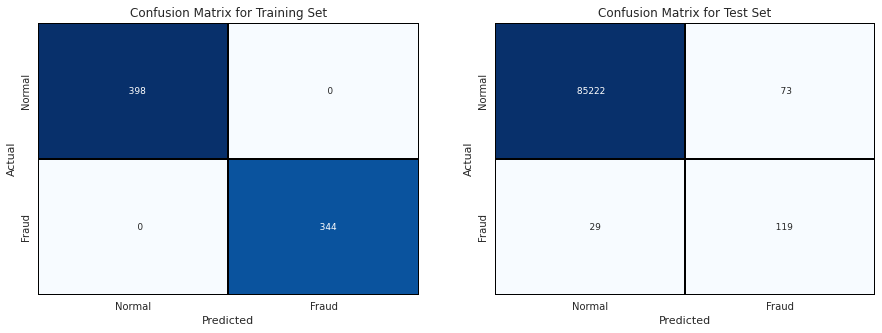

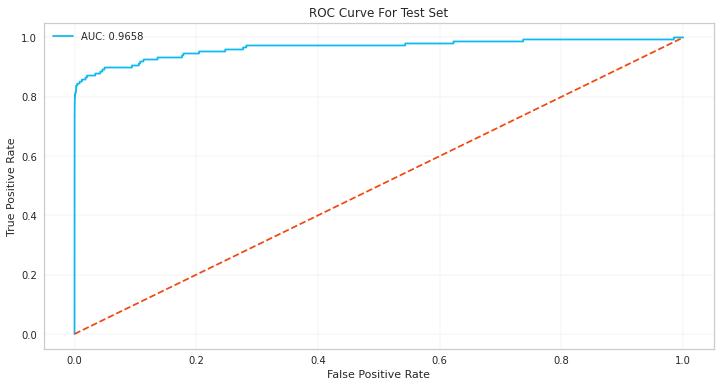

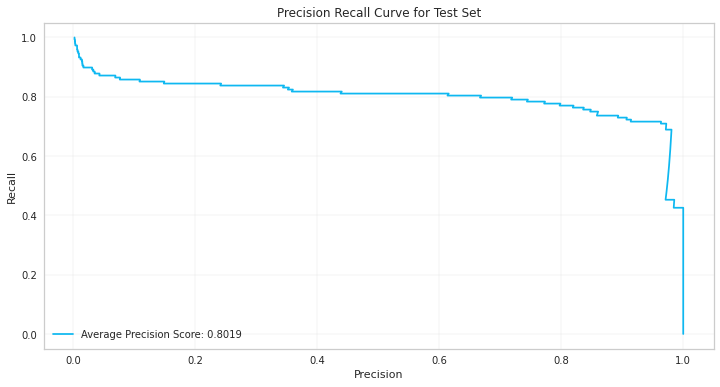

In [45]:
model_results(lgbc, Xtr_cnn1, ytr_cnn1, X_test, y_test)

In [46]:
# %%time
# Xtr_cnn1000, ytr_cnn1000 = cnn1000.fit_resample(X_train, y_train)

# Xtr_cnn1000.to_csv("X_train_cnn_s1000.csv")
# ytr_cnn1000.to_csv("y_train_cnn_s1000.csv")

Xtr_cnn1000 = pd.read_csv("../input/notebookd714576bc0/X_train_cnn_s1000.csv").drop("Unnamed: 0", axis = 1)
ytr_cnn1000 = pd.read_csv("../input/notebookd714576bc0/y_train_cnn_s1000.csv").drop("Unnamed: 0", axis = 1)

# CondensedNearestNeighbour, Number of samples to extract in order to build the set S = 1000

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000      1175
      Fraud      1.000     1.000     1.000     1.000     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000      1519

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.999     0.777     0.999     0.881     0.794     85295
      Fraud      0.653     0.777     0.999     0.710     0.881     0.759       148

avg / total      0.999     0.999     0.777     0.999     0.881     0.794     85443

Roc-Auc Score:  0.9727 



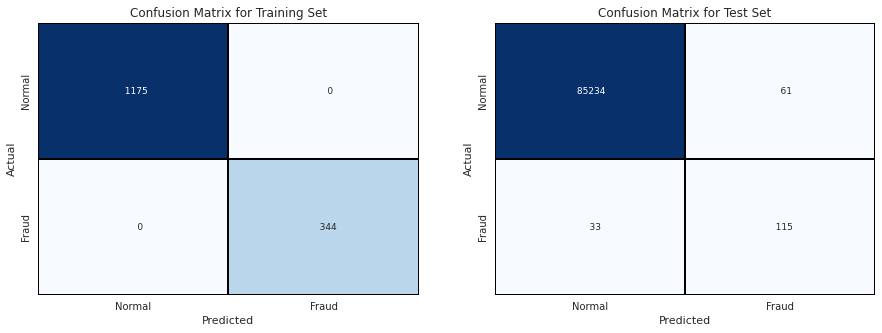

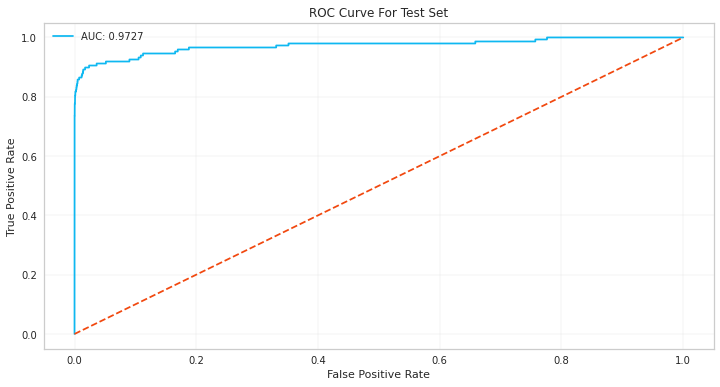

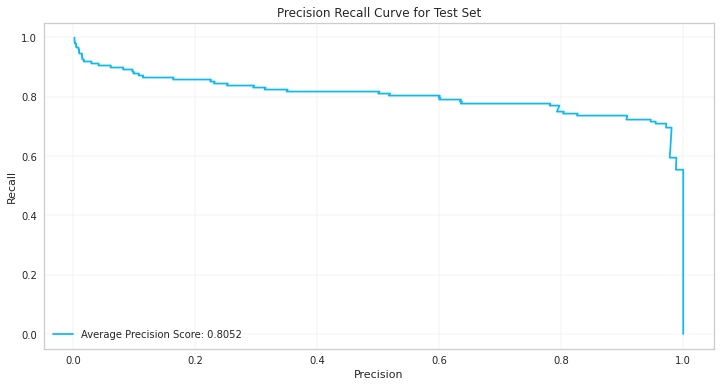

In [47]:
model_results(lgbc, Xtr_cnn1000, ytr_cnn1000, X_test, y_test)

In [48]:
# %%time
# Xtr_cnn10000, ytr_cnn10000 = cnn10000.fit_resample(X_train, y_train)

# Xtr_cnn10000.to_csv("X_train_cnn_s10000.csv")
# ytr_cnn10000.to_csv("y_train_cnn_s10000.csv")

Xtr_cnn10000 = pd.read_csv("../input/notebookd714576bc0/X_train_cnn_s10000.csv").drop("Unnamed: 0", axis = 1)
ytr_cnn10000 = pd.read_csv("../input/notebookd714576bc0/y_train_cnn_s10000.csv").drop("Unnamed: 0", axis = 1)

# CondensedNearestNeighbour, Number of samples to extract in order to build the set S = 10000

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000     10063
      Fraud      1.000     1.000     1.000     1.000     1.000     1.000       344

avg / total      1.000     1.000     1.000     1.000     1.000     1.000     10407

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     0.777     1.000     0.881     0.794     85295
      Fraud      0.858     0.777     1.000     0.816     0.881     0.760       148

avg / total      0.999     0.999     0.777     0.999     0.881     0.794     85443

Roc-Auc Score:  0.9709 



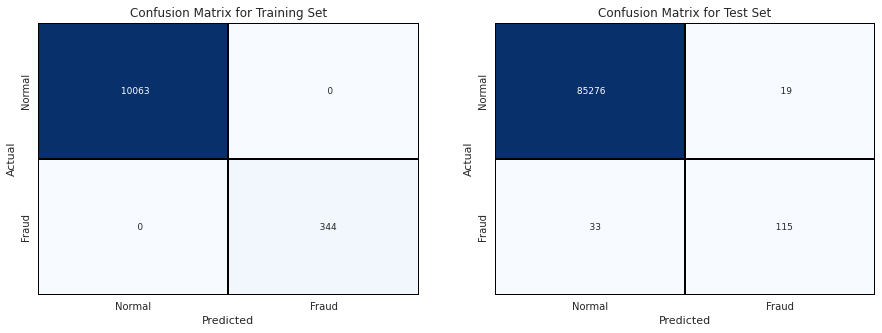

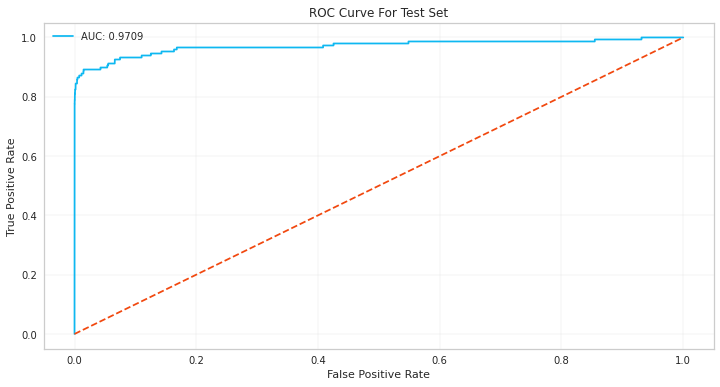

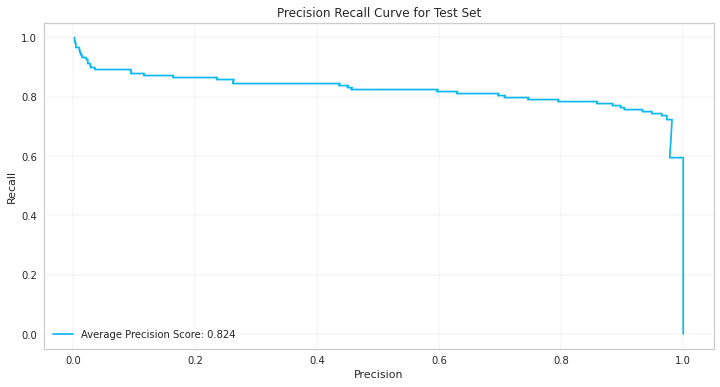

In [49]:
model_results(lgbc, Xtr_cnn10000, ytr_cnn10000, X_test, y_test)

In [50]:
enn = EditedNearestNeighbours(sampling_strategy = "not minority", n_neighbors = 3, n_jobs = -1)

In [51]:
%%time
Xtr_enn, ytr_enn = enn.fit_resample(X_train, y_train)

CPU times: user 14min 33s, sys: 478 ms, total: 14min 34s
Wall time: 3min 44s


# EditedNearestNeighbours

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      0.999     0.998     0.706     0.999     0.840     0.725    198898
      Fraud      0.352     0.706     0.998     0.470     0.840     0.684       344

avg / total      0.998     0.997     0.707     0.998     0.840     0.725    199242

Roc-Auc Score:  0.8542 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      0.999     0.997     0.635     0.998     0.796     0.656     85295
      Fraud      0.260     0.635     0.997     0.369     0.796     0.610       148

avg / total      0.998     0.996     0.636     0.997     0.796     0.656     85443

Roc-Auc Score:  0.8028 



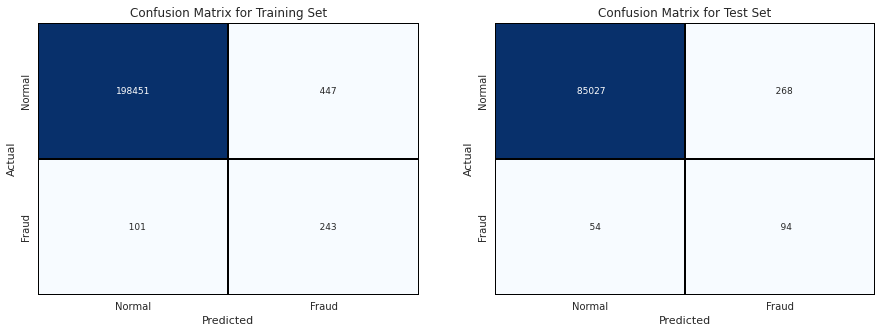

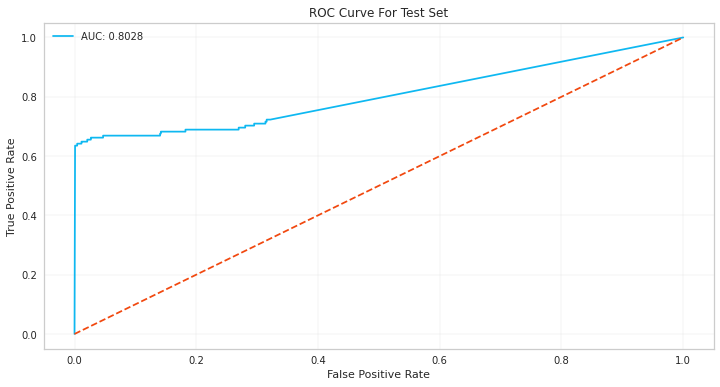

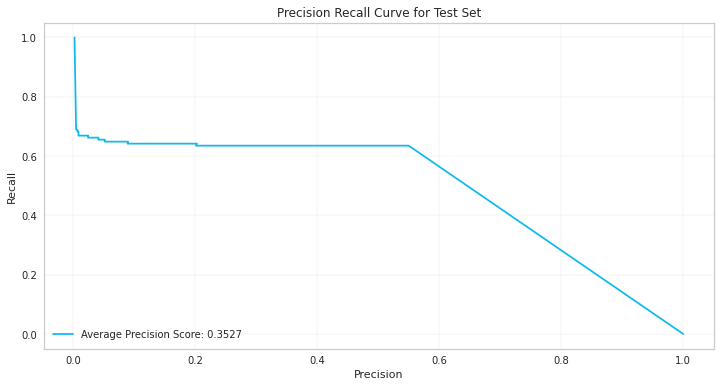

In [52]:
model_results(lgbc, Xtr_enn, ytr_enn, X_test, y_test)

In [53]:
%%time

tomek = TomekLinks(sampling_strategy = "all", n_jobs = -1)

Xtr_tomek, ytr_tomek = tomek.fit_resample(X_train, y_train)

CPU times: user 9min 59s, sys: 308 ms, total: 9min 59s
Wall time: 2min 35s


# TomekLinks

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      0.999     0.997     0.402     0.998     0.633     0.425    198999
      Fraud      0.164     0.402     0.997     0.233     0.633     0.377       323

avg / total      0.998     0.996     0.403     0.997     0.633     0.425    199322

Roc-Auc Score:  0.6965 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      0.999     0.996     0.358     0.998     0.597     0.380     85295
      Fraud      0.141     0.358     0.996     0.202     0.597     0.334       148

avg / total      0.997     0.995     0.359     0.996     0.597     0.379     85443

Roc-Auc Score:  0.669 



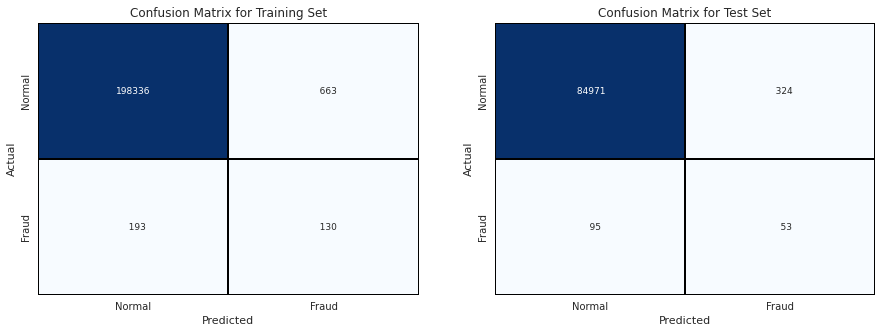

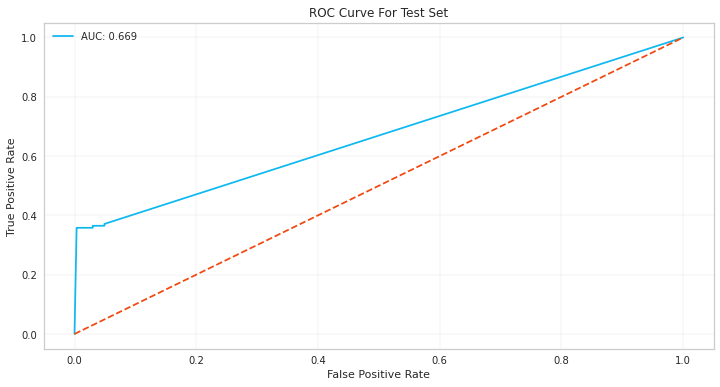

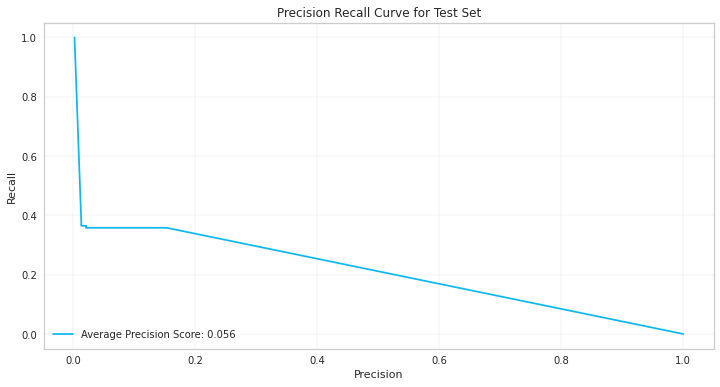

In [54]:
model_results(lgbc, Xtr_tomek, ytr_tomek, X_test, y_test)

# SMOTETomek, (SMOTE ratio = 1/10)

In [55]:
smotetomek = SMOTETomek(sampling_strategy='not minority', random_state=SEED, smote=smote_01, tomek=tomek, n_jobs=-1)

In [56]:
Xtr_smote_tomek, ytr_smote_tomek = smotetomek.fit_resample(X_train, y_train)

For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     1.000     1.000     1.000     1.000    199020
      Fraud      1.000     1.000     1.000     1.000     1.000     0.999     19902

avg / total      1.000     1.000     1.000     1.000     1.000     1.000    218922

Roc-Auc Score:  1.0 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     1.000     0.824     1.000     0.908     0.839     85295
      Fraud      0.841     0.824     1.000     0.833     0.908     0.810       148

avg / total      0.999     0.999     0.825     0.999     0.908     0.839     85443

Roc-Auc Score:  0.9699 



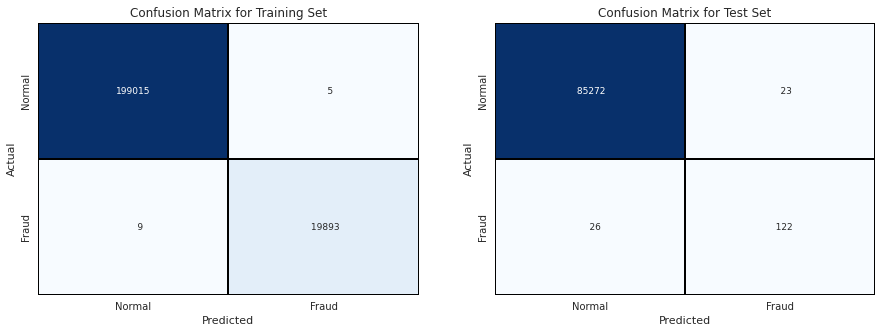

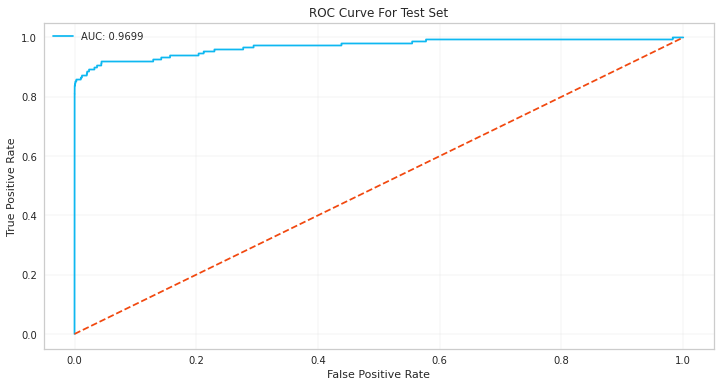

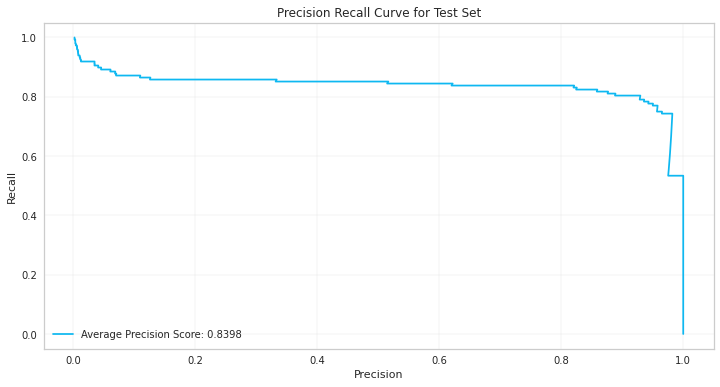

In [57]:
model_results(lgbc, Xtr_smote_tomek, ytr_smote_tomek, X_test, y_test)

In [58]:
%%time

enn = EditedNearestNeighbours(sampling_strategy='not minority', n_neighbors=1, n_jobs=-1)

Xtr_enn, ytr_enn = enn.fit_resample(X_train, y_train)

CPU times: user 9min 47s, sys: 410 ms, total: 9min 47s
Wall time: 2min 32s


For training set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      1.000     0.999     0.779     1.000     0.882     0.796    198982
      Fraud      0.715     0.779     0.999     0.745     0.882     0.761       344

avg / total      0.999     0.999     0.779     0.999     0.882     0.796    199326

Roc-Auc Score:  0.9071 

For test set: 

                   pre       rec       spe        f1       geo       iba       sup

     Normal      0.999     0.998     0.628     0.998     0.792     0.650     85295
      Fraud      0.315     0.628     0.998     0.420     0.792     0.604       148

avg / total      0.998     0.997     0.629     0.997     0.792     0.650     85443

Roc-Auc Score:  0.7513 



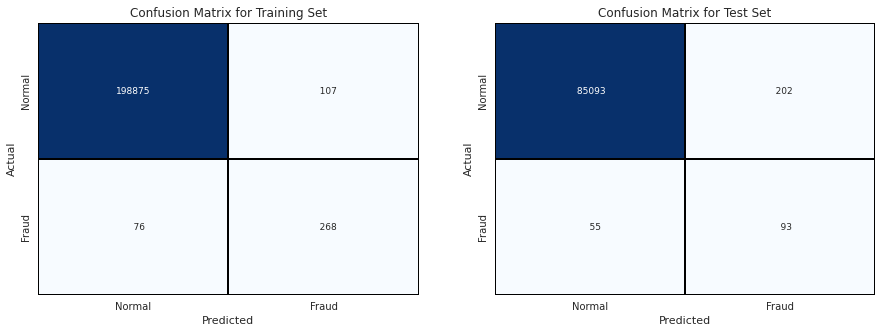

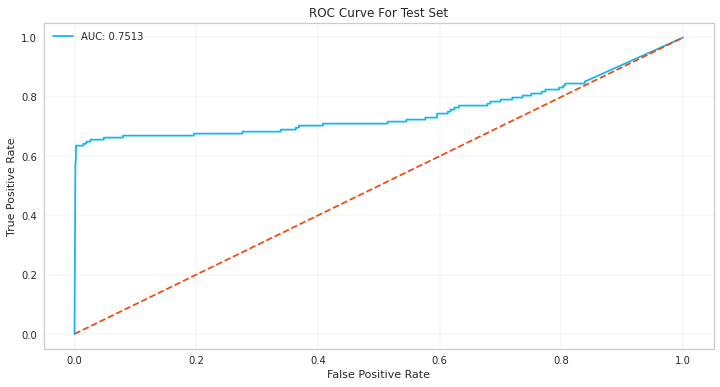

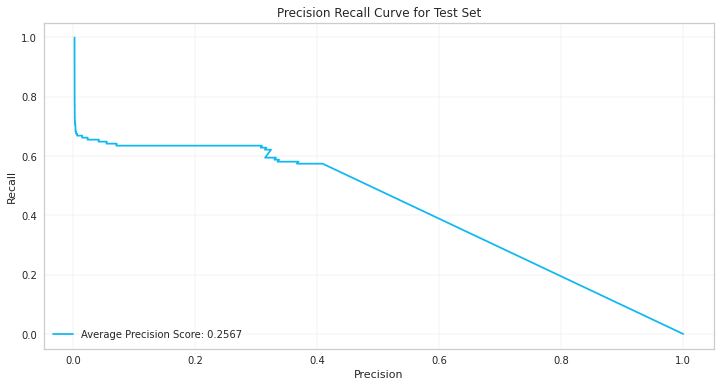

In [59]:
model_results(lgbc, Xtr_enn, ytr_enn, X_test, y_test)